## Решающие деревья

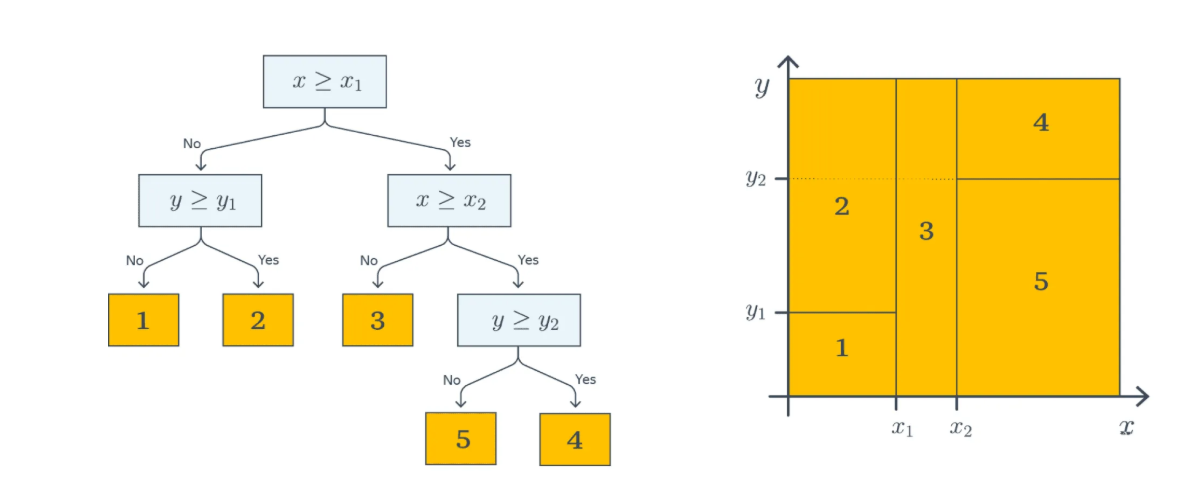
- В каждом узле этого дерева находится предикат. Если предикат верен для текущего примера из выборки, мы переходим в правого потомка, если нет — в левого. В данном примере все предикаты — это просто взятие порога по значению какого-то признака:
$$
B(x, j, t) = [x_j \leq t]
$$
#### Свойства:
- выученная функция — кусочно-постоянная, из-за чего производная равна нулю везде, где задана. Следовательно, о градиентных методах при поиске оптимального решения можно забыть;
- дерево решений (в отличие от, например, линейной модели) не сможет экстраполировать зависимости за границы области значений обучающей выборки;
- дерево решений способно идеально приблизить обучающую выборку и ничего не выучить (то есть такой классификатор будет обладать низкой обобщающей способностью): для этого достаточно построить такое дерево, в каждый лист которого будет попадать только один объект. Следовательно, при обучении нам надо не просто приближать обучающую выборку как можно лучше, но и стремиться оставлять дерево как можно более простым, чтобы результат обладал хорошей обобщающей способностью.

Предсказание: [0]
Реальный класс: 0


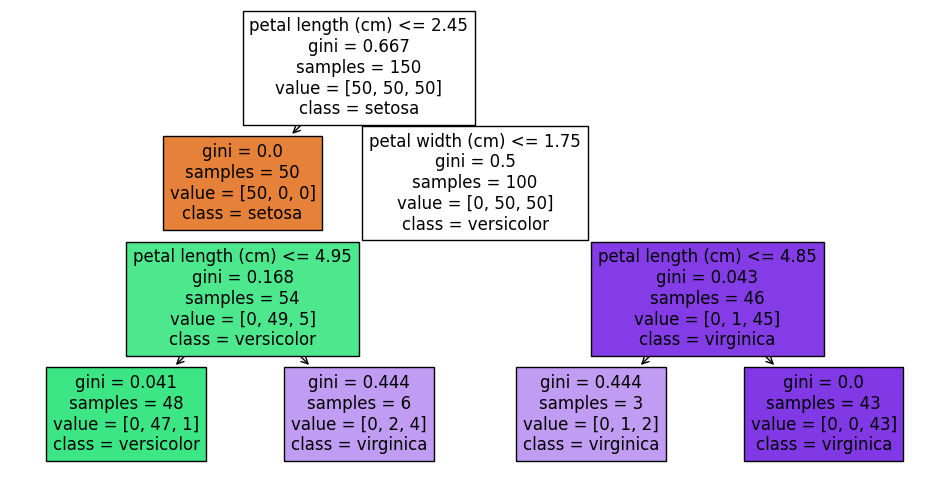

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

X, y = load_iris(return_X_y=True)

tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

print("Предсказание:", tree.predict([X[0]]))
print("Реальный класс:", y[0])

plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=load_iris().feature_names, class_names=load_iris().target_names, filled=True)
plt.show()

### Алгоритмы построение дерева

#### 1. Начинаем с корня
В начале у нас есть вся обучающая выборка $X$.  
Корень дерева соответствует **всем данным**.

#### 2. Проверяем критерий остановки
Если выборка в узле "достаточно простая" (например, там мало объектов или они почти все одного класса) → делаем **лист**.  
В лист записываем ответ:
  - для классификации — самый частый класс,  
  - для регрессии — среднее (или медиану) целевой переменной.  

#### 3. Если останавливаться рано — ищем разбиение (сплит)
- Нужно выбрать признак $j$ и порог $t$, чтобы поделить объекты:
  - левый лист $X_\ell$: объекты, у которых $x_j \leq t$  
  - правый лист $X_r$: объекты, у которых $x_j > t$  
- Но сплитов может быть очень много → выбираем **лучший** по некоторому критерию (**Branch**).  

#### 4. Рекурсия
Для каждой из подвыборок $X_\ell$ и $X_r$ повторяем процесс:
- проверяем критерий остановки,  
- если не остановились → снова ищем лучший сплит,  
- и так далее.  

### Критерии ветвления

Идея: в каждом узле дерева выбирается такое разбиение, которое делает выборки в листьях более **однородными**.  

Для этого используется понятие **информативности (impurity)**, чем она ниже, тем лучше объекты в листе можно приблизить константным значением:

$$
H(X_m) = \min_{c \in Y} \frac{1}{|X_m|} \sum_{(x_i, y_i) \in X_m} L(y_i, c)
$$

- $X_m$ — множество объектов в узле  
- $c$ — константный прогноз в листе  
- $L(y_i, c)$ — функция потерь  

Чем меньше $H(X_m)$, тем более однороден узел.


#### Информативность сплита (Branch criterion)

При разбиении узла $X_m$ на левый $X_l$ и правый $X_r$, критерий качества вычисляется как:

$$
Branch(X_m, j, t) = |X_m| \cdot H(X_m) - |X_l| \cdot H(X_l) - |X_r| \cdot H(X_r)
$$

- $j$ — выбранный признак  
- $t$ — порог сплита  
- $H(X)$ — информативность подмножества  

Чем больше значение, тем лучше разбиение.



#### 1. Регрессия: MSE

Функция потерь:

$$
L(y_i, c) = (y_i - c)^2
$$

- Оптимальное $c$ — среднее $\bar{y}$  
- Информативность узла равна дисперсии:

$$
H(X_m) = \frac{1}{|X_m|} \sum_{(x_i, y_i) \in X_m} (y_i - \bar{y})^2
$$

#### 2. Регрессия: MAE

Функция потерь:

$$
L(y_i, c) = |y_i - c|
$$

- Оптимальное $c$ — медиана  
- Информативность узла — среднее абсолютное отклонение от медианы:

$$
H(X_m) = \frac{1}{|X_m|} \sum_{(x_i, y_i) \in X_m} |y_i - \text{Median}(Y)|
$$

#### 3. Классификация: Misclassification error

Функция потерь:

$$
L(y_i, c) = I[y_i \neq c]
$$

- Оптимальный прогноз $c$ — наиболее частый класс $k^*$  
- Информативность узла:

$$
H(X_m) = 1 - p_{k^*}
$$

где $p_{k^*}$ — доля объектов класса $k^*$ в $X_m$.


#### 4. Классификация: Энтропия

Информативность:

$$
H(X_m) = - \sum_{k=1}^K p_k \log p_k
$$

где $p_k$ — доля объектов класса $k$.  

Чем меньше энтропия, тем более однороден узел.



#### 5. Классификация: Критерий Джини

Информативность:

$$
H(X_m) = \sum_{k=1}^K p_k (1 - p_k)
$$

или эквивалентно:

$$
H(X_m) = 1 - \sum_{k=1}^K p_k^2
$$

Можно интерпретировать как $H(X_m)$ — математическое ожидание числа объектов, которые будут **неправильно классифицированы**, если мы случайно присвоим метки объектам в узле по распределению $(p_1, ..., p_K)$.

- Для **регрессии**:
  - MSE → среднее, дисперсия
  - MAE → медиана, отклонение от медианы
- Для **классификации**:
  - Misclassification error → доля ошибок
  - Энтропия → мера неопределённости
  - Джини → мера случайной ошибки



In [3]:
import numpy as np

y_node = np.array([0, 0, 0, 1, 1, 2, 2, 2, 2, 2])

def gini_index(y):
    """Вычисление индекса Джини для узла"""
    classes, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return 1 - np.sum(p ** 2)

H = gini_index(y_node)
print("Индекс Джини узла:", H)

Индекс Джини узла: 0.62


### Особенности данных
- Категориальные признаки: можно упорядочить по целевой переменной, чтобы работать как с числовыми.

- Пропуски:

    - На обучении → учитываются в обоих поддеревьях с весами

    - На применении → предсказания усредняются по этим же весам

    - Для категориальных → можно выделить отдельную категорию «пропущено».

### Методы регуляризации в решающих деревьях
Деревья легко переобучаются и процесс ветвления надо в какой-то момент останавливать.

Для этого есть разные критерии, обычно используются все сразу:
- ограничение по максимальной глубине дерева;
- ограничение на минимальное количество объектов в листе;
- ограничение на максимальное количество листьев в дереве;
- требование, чтобы функционал качества Branch при делении текущей подвыборки на две улучшался не менее чем на s процентов.

- проверять критерии прямо во время построения дерева, такой способ называется pre-pruning или early stopping;
- построить дерево жадно без ограничений, а затем провести стрижку (pruning), то есть удалить некоторые вершины из дерева так, чтобы итоговое качество упало не сильно, но дерево начало подходить под условия регуляризации. При этом качество стоит измерять на отдельной, отложенной выборке.